In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import itertools

# load the data
data = pd.read_csv('../data/benchmark_features.csv')
#data = pd.read_csv('../data/final_predictors.csv')
#data = pd.read_csv('../data/full_list_of_features.csv')

print(data.shape)
display(data)


(1321, 62)


,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4,survey_opiates_0,survey_opiates_4,meds_methadone_0,meds_buprenorphine_0,meds_methadone_1,...,pex_musculoskeletal,pex_gi_system,pex_extremeties,pex_neurological,pex_gen_appearance,pex_ears_nose_throat,pex_head_neck,pex_cardio,pex_skin,dropout
0,1.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,8.0,0.0,...,abnormal,abnormal,normal,normal,normal,normal,normal,normal,normal,0.0
1,1.0,1.0,1.0,1.0,1.0,30.0,5.0,0.0,8.0,0.0,...,normal,abnormal,normal,normal,abnormal,abnormal,normal,normal,abnormal,0.0
2,1.0,1.0,1.0,1.0,1.0,30.0,9.0,30.0,0.0,170.0,...,normal,normal,normal,normal,normal,normal,normal,normal,abnormal,0.0
3,1.0,1.0,0.0,1.0,1.0,30.0,6.0,0.0,16.0,0.0,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,0.0
4,1.0,1.0,1.0,1.0,1.0,5.0,0.0,0.0,16.0,0.0,...,normal,abnormal,abnormal,normal,abnormal,abnormal,normal,normal,abnormal,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,1.0,1.0,1.0,1.0,1.0,20.0,0.0,0.0,0.0,0.0,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,1.0
1317,1.0,1.0,1.0,1.0,1.0,0.0,0.0,150.0,0.0,0.0,...,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,1.0
1318,1.0,1.0,1.0,1.0,1.0,30.0,0.0,0.0,0.0,0.0,...,abnormal,normal,normal,normal,normal,normal,normal,normal,normal,1.0
1319,1.0,1.0,1.0,1.0,1.0,30.0,0.0,0.0,2.0,0.0,...,normal,normal,abnormal,normal,normal,normal,normal,normal,abnormal,1.0


![pipelines](/Users/danherman/Desktop/precision_medicine/images/pipelines.png)

## Import Require Libraries

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss
import lifelines

# assign X and y
X, y = data.drop('dropout', axis=1), data['dropout']

# print shape
X.shape, y.shape

((1321, 61), (1321,))

## Split the Data
First split into dev and test.  Test should equal 20% of data<br>
Then split the dev data into train and validation.  Validation should equal 20% of data<br>

In [28]:
# split the data to traininig, validation and test sets
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.165, random_state=0)

# split the development set to training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.20, random_state=0)

# print the shape for each dataset
print('Training set:', X_train.shape, y_train.shape[0])
print('Validation set:', X_val.shape, y_val.shape[0])
print('Test set:', X_test.shape, y_test.shape[0])


Training set: (882, 61) 882
Validation set: (221, 61) 221
Test set: (218, 61) 218


## Assign columns to dtype for pipelines

In [29]:
# start with int and float
int_columns = [col for col in X_train.columns if X_train[col].dtype == 'int64']
float_columns = [col for col in X_train.columns if X_train[col].dtype == 'float64']

# Combine both lists if you need columns of both types
numeric_columns = int_columns + float_columns

# get categorical columns
categorical_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']

### Using C-Index as calssification metric

## First Run Pipelines without Param Grid to show benchmark model

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import make_scorer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import helper

# Define the custom scoring function
def cindex_scorer(y_true, y_pred):
    return lifelines.utils.concordance_index(y_true, y_pred)

# Create a scorer object
cindex = make_scorer(cindex_scorer, greater_is_better=True)

# Instantiate the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', IterativeImputer(max_iter=10, random_state=0)),
            ('scaler', StandardScaler())
        ]), numeric_columns),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_columns)
    ])

# Define the classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier()
}

# Define pipelines for each classifier
pipelines = {
    name: Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', classifier)])
    for name, classifier in classifiers.items()
}


# Initialize results storage
results = []

# Evaluate each pipeline without GridSearchCV
for name, pipeline in pipelines.items():
    print(f"Training {name}...")
    pipeline.fit(X_train, y_train)
    
    y_train_pred = pipeline.predict(X_train)
    y_val_pred = pipeline.predict(X_val)
    y_test_pred = pipeline.predict(X_test)
    
    train_accuracy = helper.cindex(y_train, y_train_pred)
    val_accuracy = helper.cindex(y_val, y_val_pred)
    test_accuracy = helper.cindex(y_test, y_test_pred)
    
    print(f"{name} - Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    results.append({
        'model': name,
        'train_accuracy': train_accuracy,
        'validation_accuracy': val_accuracy,
        'test_accuracy': test_accuracy
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

Training LogisticRegression...
LogisticRegression - Train Accuracy: 0.7673, Validation Accuracy: 0.6933
Training RandomForest...
RandomForest - Train Accuracy: 1.0000, Validation Accuracy: 0.7098
Training XGBoost...
XGBoost - Train Accuracy: 1.0000, Validation Accuracy: 0.7047


In [31]:
# get largest value in test_accuracy

results_df

,model,train_accuracy,validation_accuracy,test_accuracy
0,LogisticRegression,0.767253,0.693338,0.688251
1,RandomForest,1.000000,0.709764,0.745810
2,XGBoost,1.000000,0.704745,0.697903


In [32]:
import matplotlib.pyplot as plt

def plot_model_accuracies(results_df):
    plt.figure(figsize=(12, 8))
    bar_width = 0.25
    index = range(len(results_df['model']))

    # Plot bars
    bars1 = plt.bar(index, results_df['train_accuracy'].values, bar_width, label='Train')
    bars2 = plt.bar([i + bar_width for i in index], results_df['validation_accuracy'].values, bar_width, label='Validation')
    bars3 = plt.bar([i + 2 * bar_width for i in index], results_df['test_accuracy'].values, bar_width, label='Test')

    # Annotate bars with accuracy values
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{height:.4f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom')

    plt.ylabel('Accuracy')
    plt.xlabel('Model')
    plt.title('Model Performance')
    plt.xticks([i + bar_width for i in index], results_df['model'].values)
    plt.legend()
    plt.show()

# Example usage:
# plot_model_accuracies(results_df)


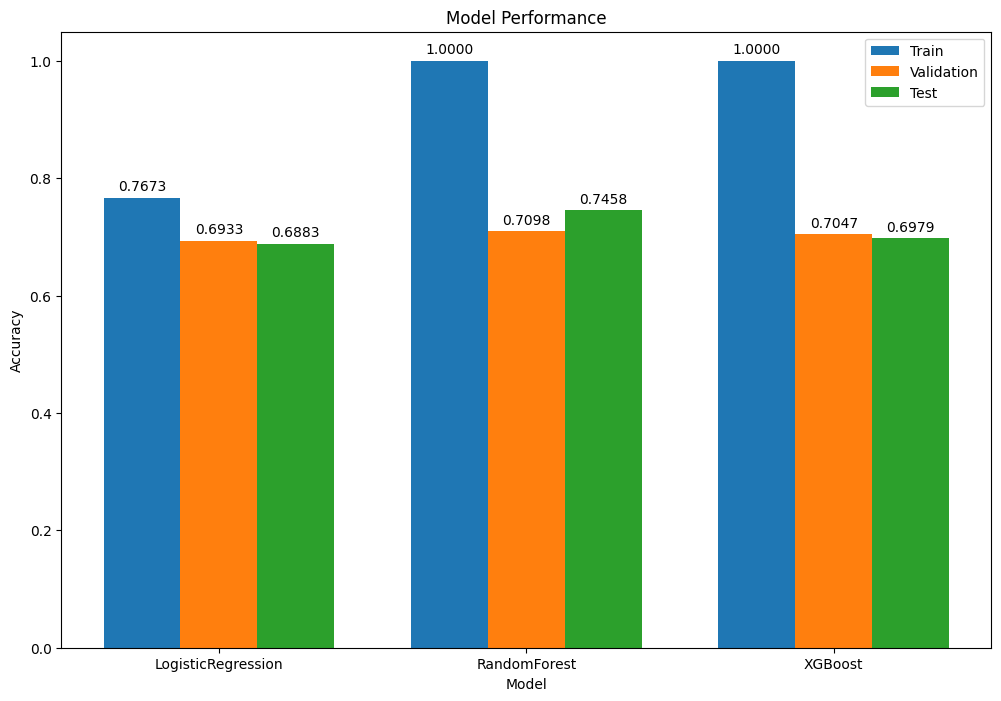

In [33]:
# plot model accuracies
plot_model_accuracies(results_df)

## Now Run the Pipelines with Param Grid to find the best model

In [34]:
# Preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer()),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Define parameter grids
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100]
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30]
    },
    'XGBoost': {
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__n_estimators': [50, 100, 200]
    }
}

# Initialize a list to store results
results = []

# count the total of param in the param_grids object
lists = param_grids.values()

# get all param combinations
param_combinations = list(itertools.product(*lists))
total_param_combinations = len(param_combinations)

# Train and evaluate each model
for name, clf in classifiers.items():
    print(f"Training: {name}")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', clf)])
    
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring=cindex)
    grid_search.fit(X_train, y_train)
    
    # Best model from grid search
    best_model = grid_search.best_estimator_
    
    # Evaluate on training set
    y_train_pred = best_model.predict(X_train)
    train_score = cindex_scorer(y_train, y_train_pred)

    
    # Evaluate on validation set
    y_val_pred = best_model.predict(X_val)
    val_score = cindex_scorer(y_val, y_val_pred)

    
    # Evaluate on test set
    y_test_pred = best_model.predict(X_test)
    test_score = cindex_scorer(y_test, y_test_pred)

    # Store results
    results.append({
        'model': name,
        'train_accuracy': train_score,
        'validation_accuracy': val_score,
        'test_accuracy': test_score,
        'Best Params': grid_search.best_params_
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
results_df

Training: Logistic Regression
[Logistic Regression/4]
Train C-Index:0.751130742232124
[Logistic Regression/4]
Val C-Index:0.7117554338808694

[Logistic Regression/4]
Test C-Index:0.7341844345003071

Training: Random Forest
[Random Forest/4]
Train C-Index:1.0
[Random Forest/4]
Val C-Index:0.7108843537414966

[Random Forest/4]
Test C-Index:0.7362463806264806

Training: XGBoost
[XGBoost/4]
Train C-Index:1.0
[XGBoost/4]
Val C-Index:0.7363115978098557

[XGBoost/4]
Test C-Index:0.7132140036851803



,model,train_accuracy,validation_accuracy,test_accuracy,Best Params
0,Logistic Regression,0.751131,0.711755,0.734184,{'classifier__C': 0.01}
1,Random Forest,1.000000,0.710884,0.736246,"{'classifier__max_depth': 30, 'classifier__n_e..."
2,XGBoost,1.000000,0.736312,0.713214,"{'classifier__learning_rate': 0.2, 'classifier..."


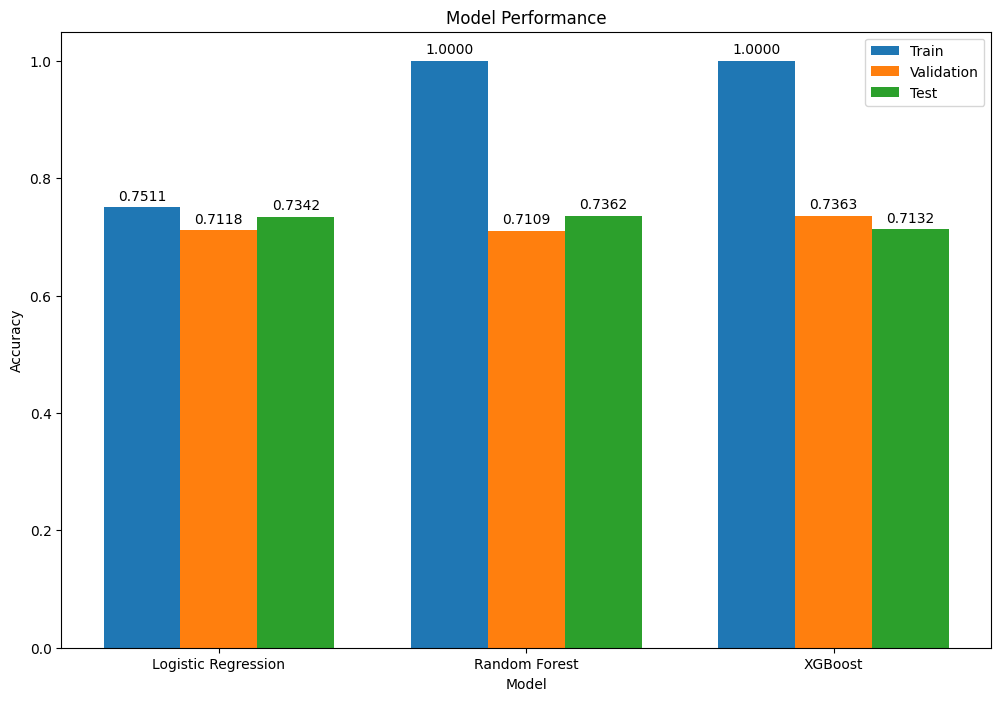

In [35]:
plot_model_accuracies(results_df)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Assuming 'data' is a DataFrame and 'dropout' is the target variable
X = data[['survey_opiates_4', 'rbs_heroine']]
y = data['dropout']

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X, y)

In [ ]:
import numpy as np

# Define the range for the grid
x_min, x_max = X['survey_opiates_4'].min() - 1, X['survey_opiates_4'].max() + 1
y_min, y_max = X['rbs_heroine'].min() - 1, X['rbs_heroine'].max() + 1

# Create a mesh grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

In [ ]:
# Flatten the grid to pass it to the model
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict the class for each point in the grid
Z = model.predict(grid)
Z = Z.reshape(xx.shape)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='survey_opiates_4', y='rbs_heroine', hue='dropout', data=data)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

# Plot the decision boundary line
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')

plt.title('Self Reported Use Week 4, Previous 30 days heroine use')
plt.xlabel('survey_opiates_4')
plt.ylabel('rbs_heroine')
plt.legend()
plt.show()

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Assuming 'data' is a DataFrame and 'dropout' is the target variable
X = data[['survey_opiates_4', 'rbs_heroine']]
y = data['dropout']

# Create a pipeline with standard scaling and XGBoost
model = make_pipeline(StandardScaler(), xgb.XGBClassifier())
model.fit(X, y)

In [ ]:
import numpy as np

# Define the range for the grid
x_min, x_max = X['survey_opiates_4'].min() - 1, X['survey_opiates_4'].max() + 1
y_min, y_max = X['rbs_heroine'].min() - 1, X['rbs_heroine'].max() + 1

# Create a mesh grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

In [ ]:
# Flatten the grid to pass it to the model
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict the class for each point in the grid
Z = model.predict(grid)
Z = Z.reshape(xx.shape)

NameError: name 'xx' is not defined

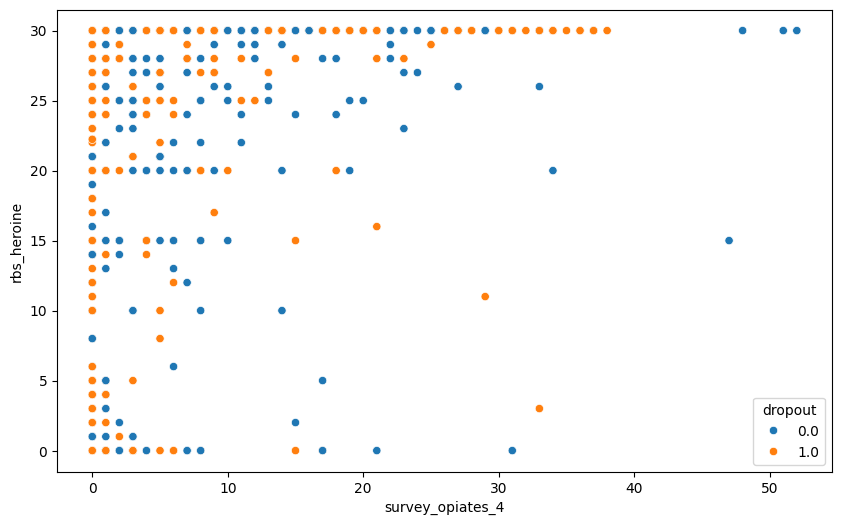

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='survey_opiates_4', y='rbs_heroine', hue='dropout', data=data)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

# Plot the decision boundary line
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')

plt.title('Withdrawal syndrome scale, medication dose and dropout')
plt.xlabel('meds_methadone_0')
plt.ylabel('cows_postdose')
plt.legend()
plt.show()